# Introduction to DataJoint

This will be our first tutorial on datajoint. Make sure you completed part 1 of HW5 and that your mySQL instance is running. 

In this tutorial we will be going over the following concepts:

* How to define a table in datajoint
* How to add data to a table
* How to search data in your database
* How to fetch data in your database
* How to delete entries
* How to drop tables/schema.
* Building table dependencies
* How to query multiple tables
* organizing/saving your tables in python files. 

This introduction has been adapted and modified from https://tutorials.datajoint.io/index.html. (NB: this linked tutorial is sometimes not up-to-date with the most recent version of datajoint) 

In [1]:
import datajoint as dj

### Clarifications

DataJoint is a WIP-type of project. This means that a lot of features are still being implemented and some of the syntax may change in the future. This is why it is important for you to be aware which version of datajoint, you are using. In general, we are currently working with the most recent version of datajoint, which is version `0.12.5`. You can check the version of datajoint as follows:

In [2]:
dj.__version__

'0.12.5'

In the first part of this homework, you may have noticed that we installed datajoint from a specific fork in github. This fork implements various features that are set to be added in future releases of the main datajoint project and/or are still being discussed. During the lectures and homework, I will always point out any features that have not yet been added to the main releases of the datajoint project, but are features that currently exist in the fork that we installed.  

On Tuesday, we will go through part 1 of the homework, a brief overview of this part of the homework, and how to navigate and see progress on the datajoint project in GitHub. On Thursday, we will review this part of the homework and introduce other datajoint concepts.

## Connecting to the database

First, we will need to configure our connection to the MySQL database. If you used the docker to initialize your SQL instance your host address is `'127.0.0.1'`, your user is `'root'`, and your password is `'simple'`. In the later lectures, we will go into setting up adding users to your database and managing user privileges.

In [3]:
# datajoint configuration
dj.config['database.host'] = '127.0.0.1'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'simple'
# we will go into this attribute later
dj.config['fetch_format'] = 'frame'

In [4]:
# connect to the database
# testing your connection
connection = dj.conn()
connection

Connecting root@127.0.0.1:3306


DataJoint connection (connected) root@127.0.0.1:3306

### Saving DataJoint configuration across session

By default, all changes made to the dj.config are reset when you reset your Python session, and thus you would have to configure the connection every time you start a new Python kernel.

To save yourself the hassle, you can save the current configuration to a local configuration file, by default called dj_local_config.json. DataJoint will automatically load the configuration file when you import DataJoint the next time.

To save the current configuration, call the save_local method on the dj.config object.


In [5]:
dj.config.save_local()

Now your configuration is successfully saved into the local configuration file.

If you would like to save this config globally, in which case you automatically load this configuration in any directory, you could do save_global()

In [6]:
dj.config.save_global()

The local configuration overwrites the global one.

### Changing the password

You can directly change the database connection password using the dj.set_password() method:

In [7]:
dj.set_password('simple')

Password updated.


Update local setting? [yes, no]:  yes


Saved settings in dj_local_conf.json


In the last lecture, we will go into managing multiple users for your database.

## Define a schema

Let us initialize a database schema that we will call `'homework1'`, where we will create all the tables for this homework. It is recommended that you always give your schema that are all lowercase identifiers. An identifier starts with a letter a to z or an underscore followed by zero or more letters, underscores and digits (0 to 9).

In [9]:
schema = dj.schema('homework1')

Follow this link for more information on creating schema: https://docs.datajoint.io/python/definition/01-Creating-Schemas.html

## Defining a table and types of tables

If you remember from the previous lecture, datajoint is an object-relational mapper (ORM). This means it maps tables in the SQL database to classes in Python. The classes in Python are not the actual tables that exist in our database!

Let's build a class in Python that maps to a table in the MySQL database, and go through each part of the Python class.

In [10]:
@schema
class FlySubject(dj.Manual):
    definition = """
    # some fly table
    subject_id : int  # id for fly subject
    ---
    age : float # age of fly in days
    sex = 'U': enum('F', 'M', 'U')  # sex of fly
    comments = null : varchar(4000)
    """

Let's start at the top. The `@schema` decorator tells datajoint to which schema this table class is assigned to in the MySQL database and it will automatically create the table in the database using the table class, if it does not yet exist in the MySQL database. 

The table will only be created successfully in the MySQL database if your class meets these conditions:
* Your class inherits from a datajoint table type (in this case it is the `Manual` table type):

    ```python 
class FlySubject(dj.Manual):
    ```
    
    The `Manual` table type is meant for tables where entries are added manually. As an overview, here are the different types of tables that exist in datajoint (we will go into each in the next lectures):
    * `Manual`
    * `Lookup`
    * `Part`
    * `Computed` and `Imported`
    * **on this datajoint fork only:** `AutoComputed` and `AutoImported`


* Your class name (here `FlySubject`) has to follow CamelCase compound word notation:
    * start with a capital letter
    * contain only alphanumerical characters (no underscores).
  
  
* Your class has a `definition` attribute that specifies the structure of your table. That is it specifies the columns/attributes of the table. The `definition` attribute is a specially formatted string:

    ```python
    definition = """
    # some fly table
    subject_id : int  # id for fly subject
    ---
    age : float # age of fly in days
    sex = 'U': enum('F', 'M', 'U')  # sex of fly
    comments = null : varchar(4000)
    """
    ```
    
For more information on the first two points, see: https://docs.datajoint.io/python/definition/02-Creating-Tables.html

Let's go through the different parts of the `definition` string attribute.

### The definition attribute

The triple quotes for the definition attribute, allows you to write a multi-line string.

#### Table comment

The first line of the string is `# some fly table`
which is the table comment. It has to start with a hash symbol. The table comment is not necessary, and you are free to leave it out. Although the table comment can be useful when you start defining more complex tables.

#### New attribute definition

The next line of the string is
`subject_id : int # id for fly subject`
which is the first attribute/column of the table. Each attribute is in a separate line. 
The new attribute definition can take the followings formats (also see https://docs.datajoint.io/python/definition/04-Definition-Syntax.html): 
```
attribute_name : data_type
attribute_name : data_type  # comment
attribute_name = default_value : data_type
attribute_name = default_value : data_type # comment
```

The `attribute_name` is the name of the attribute. It must be in lowercase, and can only contain alphanumerical characters and underscores (snake-case). 

The `data_type` determines what kind of data can go into that attribute. Throughout the lectures and homework, we will be working with various data types and go into details of some of the special data types that exist in datajoint. Here is a list of MySQL and datajoint-specific data types supported with DataJoint: https://docs.datajoint.io/python/definition/06-Datatypes.html. Please take a look at the data types to get an overview, what is out there. We will go through the specific data types during the lectures. 

The `comment` and `default_value` are optional parts of a new attribute/column definition. The default value `null` allows you to not have to insert any data for a column. A primary key column cannot have the default value `null`.

#### Primary keys vs. Non-primary/dependent attributes

The `---` separator in the third line separates primary keys from dependent attributes. Remember, the primary keys are attributes that **uniquely identify** entries in a table. Here we only have one primary key `subject_id`, and thus every entry in the table must have a distinct `subject_id`. 

To ensure entry integrity, DataJoint enforces the specification of primary keys, which is not a necessary component of MySQL (see https://docs.datajoint.io/python/definition/07-Primary-Key.html). 

#### Initialize your table

You do not need to pass anything to initialize your table. After initialization, you will see if you current table is empty or not.

In [11]:
fly_subject = FlySubject()
fly_subject

subject_id id for fly subject,age age of fly in days,sex sex of fly,comments


## Adding data to a table

### Inserting one entry at a time

You can insert a single entry into your table by using the `insert1` method. This method either accepts a *tuple* or *list* with values in the order ot he attributes or it accepts a *dictionary*, where the keys correspond to the column/attribute names (any order). The dictionary format is especially usefull if you have columns where you do not need to specify data (i.e. you defined a default): 

In [12]:
# using a tuple
fly_subject.insert1((0, 3.4, 'M', 'This subject was particularly eager to eat my cake and have it too.'))

# using a dictionary
fly_subject.insert1({'subject_id': 1, 'age':4.5})

### Data integrity

As previously mentioned, we want to avoid **data duplication**. So if you try to insert the same entry again (i.e. with the same primary keys), you will get an error:

In [13]:
fly_subject.insert1({'subject_id': 1, 'age':4.5})

DuplicateError: ("Duplicate entry '1' for key 'PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

#### NB

Refreshing your Python kernel does not change the MySQL database nor what you have already inserted into the database. Your Python code just links to it and allows you to execute commands in MySQL. So if you were to run everything again after refreshing the kernel, you will get a duplicate error in the earlier cell unless you deleted those entries or that table/schema beforehand. 

### Inserting multiple entries

You can also insert multiple entries into your database using the `insert` method. This accepts a list of dictionarie/tuples/lists or a numpy recarray. If you are using dictionaries, every element must contain the same keys:

In [14]:
fly_subject.insert([
    {'subject_id': 2, 'age':4.5, 'sex': 'M', 'comments':None}, 
    {'subject_id': 3, 'age':7.5, 'sex': 'F', 'comments':'some comments'}, 
    {'subject_id': 4, 'age':9.5, 'sex': 'F', 'comments':'other comments'}, 
])

### Now take a look at your table again and you will see that it has a bunch of entries

In [15]:
fly_subject

subject_id id for fly subject,age age of fly in days,sex sex of fly,comments
0,3.4,M,This subject was particularly eager to eat my cake and have it too.
1,4.5,U,None
2,4.5,M,None
3,7.5,F,some comments
4,9.5,F,other comments


## Search data in your table

You can search your table using restrictions. There are two types of restrictions: 
* `A & cond`: The subset of entries in table `A` that meet condition `cond`
* `A - cond`: The subset of entries in table `A` that do not meed condition `cond`.

`cond` can be various Python objects:
* string formatted as a SQL where clause: https://www.tutorialgateway.org/mysql-where-clause
* a dictionary, where the keys are the column names and the values are the values that should be matched
* another datajoint table object with non-matching depedent attribute/column names.

Restrictions can also be chained, e.g.:
```
A & cond0 & cond1 - cond2
```

Let's see some examples for our table `FlySubject`.

In [16]:
fly_subject & 'age > 5'

subject_id id for fly subject,age age of fly in days,sex sex of fly,comments
3,7.5,F,some comments
4,9.5,F,other comments


In [17]:
fly_subject & 'age > 5' & 'sex = "M"'

subject_id id for fly subject,age age of fly in days,sex sex of fly,comments


In [18]:
fly_subject & {'sex': 'M', 'age': 4.5}

subject_id id for fly subject,age age of fly in days,sex sex of fly,comments
2,4.5,M,None


In [19]:
fly_subject - {'sex':'M'}

subject_id id for fly subject,age age of fly in days,sex sex of fly,comments
1,4.5,U,None
3,7.5,F,some comments
4,9.5,F,other comments


### Projection .proj(): focus on attributes of interest

Projection is used to select attributes (columns) from a table and to rename them.

Let's see some examples

In [20]:
fly_subject.proj() # only the primary keys

subject_id id for fly subject
0
1
2
3
4


In [21]:
fly_subject.proj('sex') # primary keys and sex column

subject_id id for fly subject,sex sex of fly
0,M
1,U
2,M
3,F
4,F


In [22]:
fly_subject.proj('sex', 'age') # primary keys and sex, age column

subject_id id for fly subject,age age of fly in days,sex sex of fly
0,3.4,M
1,4.5,U
2,4.5,M
3,7.5,F
4,9.5,F


In [23]:
fly_subject.proj(age_in_days='age') # rename age into age_in_days

subject_id id for fly subject,age_in_days age of fly in days
0,3.4
1,4.5
2,4.5
3,7.5
4,9.5


In [24]:
(fly_subject & {'sex':'M'}).proj() # restrict then project

subject_id id for fly subject
0
2


In [25]:
(fly_subject.proj() & {'sex':'M'}) # project then restrict
# since we projected first the sex column dropped before we restricted by it

subject_id id for fly subject
0
1
2
3
4


## Fetching your data

So far, we have performed all searches on the MySQL side and did not get any data, so that we can perform operations in Python. 

You can fetch data into Python using the `fetch` or `fetch1` method. If you are using `fetch1`, your table or restricted table can only contain one entry. `fetch1` returns a dictionary, whereas `fetch` can return a numpy.recarray, a pandas.DataFrame, or a list of dicts:

In [26]:
fly_subject.fetch() # the index is set to the primary keys

,age,sex,comments
subject_id,,,
0,3.4,M,This subject was particularly eager to eat my ...
1,4.5,U,None
2,4.5,M,None
3,7.5,F,some comments
4,9.5,F,other comments


In [27]:
fly_subject.fetch(as_dict=True)

[{'subject_id': 0,
  'age': 3.4,
  'sex': 'M',
  'comments': 'This subject was particularly eager to eat my cake and have it too.'},
 {'subject_id': 1, 'age': 4.5, 'sex': 'U', 'comments': None},
 {'subject_id': 2, 'age': 4.5, 'sex': 'M', 'comments': None},
 {'subject_id': 3, 'age': 7.5, 'sex': 'F', 'comments': 'some comments'},
 {'subject_id': 4, 'age': 9.5, 'sex': 'F', 'comments': 'other comments'}]

In [28]:
fly_subject.fetch(format='array') # here we have it as a record array

array([(0, 3.4, 'M', 'This subject was particularly eager to eat my cake and have it too.'),
       (1, 4.5, 'U', None), (2, 4.5, 'M', None),
       (3, 7.5, 'F', 'some comments'), (4, 9.5, 'F', 'other comments')],
      dtype=[('subject_id', '<i8'), ('age', '<f8'), ('sex', 'O'), ('comments', 'O')])

as you saw maybe at the beginning, you can globally set the default format to be a dataframe or record array by setting the `'fetch_format'` in your `dj.config` to either `'frame'` or `'array'`, respectively.

You can also fetch restricted and projected tables, e.g.:

In [29]:
table = (fly_subject - {'sex':'M'}).fetch() # here i am also assigning the fetch table to the table variable
table  # look no male flies

,age,sex,comments
subject_id,,,
1,4.5,U,None
3,7.5,F,some comments
4,9.5,F,other comments


In [30]:
(fly_subject & {'sex':'M'}).proj().fetch() # fetching a projection

""
subject_id
0
2


In [31]:
(fly_subject & {'sex':'M', 'age':4.5}).fetch1() # fetching a single entry

{'subject_id': 2, 'age': 4.5, 'sex': 'M', 'comments': None}

NB: if there is more than one or zero entries when you use fetch1 an error will be thrown:

In [32]:
(fly_subject).fetch1()

DataJointError: fetch1 should only be used for relations with exactly one tuple

## Deleting entries

Sometimes you want to delete an existing entry. For example, if you entered it information incorrectly, you may want to reinsert the entry. You can delete entries easily with the `delete` method. Let's delete all the male flies:

In [34]:
(fly_subject & {'sex':'M'}).delete()

Nothing to delete


Proceed? [yes, No]:  yes


Commited.


In [35]:
fly_subject

subject_id id for fly subject,age age of fly in days,sex sex of fly,comments
1,4.5,U,None
3,7.5,F,some comments
4,9.5,F,other comments


## Dropping tables and schemas

You can also drop whole tables. This means that not just the data in tables are deleted on the MySQL server but the table metadata (i.e. the definition) and all are deleted as well on the MySQL server. To do this you can use the `drop` method. Let's drop the table, we have created:

In [36]:
fly_subject.drop()

`homework1`.`fly_subject` (3 tuples)


Proceed? [yes, No]:  yes


Tables dropped.  Restart kernel.


You can also delete a whole schema, which will drop all tables within that schema. Let's do that for our schema `homework1`:

In [37]:
schema.drop()

Proceed to delete entire schema `homework1`? [yes, No]:  yes


Now we are back to zero!

## Table dependencies

As mentioned in the previous lecture, you can link up different tables, which can help you build a workflow and maintain data integrity across different tables. To specify table dependencies in the table `definition` using the `->` symbol. In the **my_database.py** file, there is an example of a table dependency. The schema in this file is called `homework2` and we have a total of three tables: `FlySubject`, `RecordingSession`, `Stimulus`.

The `RecordingSession` table depends on both the `FlySubject` and `Stimulus` tables. This means that the primary keys of the `FlySubject` and `Stimulus` tables are inherited by `RecordingSession`. However, they are inherited in two different ways. In the case of the `FlySubject` table, the primary keys of `FlySubject` become part of the primary keys of `RecordingSession`. In the case of the `Stimulus` table, the primary keys of `Stimulus` are dependent attributes in the `RecordingSession` table. Since `RecordingSession` inherits `FlySubject` and `Stimulus`, it is necessary to have this class below the other two in the python file.

Let's import this file in order to initialize the schema and tables and use them in this iPython kernel. 

NB: Since we configure our database connection in this iPython kernel, we did not have to specify it in the my_database.py file. Usually, you define your tables of one schema in a python file and configure your connection either in another python file or a notebook, which imports the python file/s with the schema and tables.

In [38]:
import my_database as db

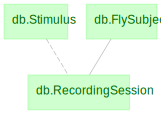

In [39]:
# you can take a look at the schema and all connections with datajoint.ERD
dj.ERD(db.schema)

In [40]:
# this is the definition for RecordingSession
print(db.RecordingSession.definition)


    # record them sessions
    -> FlySubject
    recording_id : int 
    ---
    -> Stimulus
    experimenter : varchar(127)
    recording_quality : enum('good', 'bad', 'ugly')
    comments = null : varchar(4000)
    


### 1) Insert 5 entries for the `FlySubject` table and 3 entries for the `Stimulus` table

In [41]:
# Your code here

Let's take a closer look at the `RecordingSession` table. Each table instance has an attribute called `heading`. The `heading` attribute itself is a class that exists in datajoint, and has some functionality that we will briefly touch upon here.

In [42]:
rec = db.RecordingSession()
rec.heading

# record them sessions
subject_id           : int                          # id for fly subject
recording_id         : int                          # 
---
stimulus_name        : varchar(31)                  # short name for stimulus
experimenter         : varchar(127)                 # 
recording_quality    : enum('good','bad','ugly')    # 
comments=null        : varchar(4000)                # 

You can see that the heading is similar to the definition, except that the dependencies have been swapped with the actual primary keys of the "parent" tables.

The heading tells you the names of the actual columns after processing the `definition` attribute.

In [43]:
# this shows all primary keys for your table
print(rec.heading.primary_key, '\n')
# this shows all the dependent/secondary attributes
print(rec.heading.secondary_attributes, '\n')
# this shows all attributes
print(rec.heading.names, '\n')
# this shows some extra metadata info of your table
# you don't need to understand its key here. It's just so that you know this information exists
print(rec.heading.table_info)

['subject_id', 'recording_id'] 

['stimulus_name', 'experimenter', 'recording_quality', 'comments'] 

['subject_id', 'recording_id', 'stimulus_name', 'experimenter', 'recording_quality', 'comments'] 

{'name': 'recording_session', 'engine': 'InnoDB', 'version': 10, 'row_format': 'Dynamic', 'rows': 0, 'avg_row_length': 0, 'data_length': 16384, 'max_data_length': 0, 'index_length': 16384, 'data_free': 0, 'auto_increment': None, 'create_time': datetime.datetime(2020, 4, 27, 12, 50, 1), 'update_time': None, 'check_time': None, 'collation': 'utf8_general_ci', 'checksum': None, 'create_options': '', 'comment': 'record them sessions'}


The actual names of the columns are the ones you need to use when inserting into the table

### 2) Insert 10 recordings into the `RecordingSession` table

Beware that the values for inherited columns from `Stimulus` and `FlySubject` must already exist in those "parent" tables when inserting into `RecordingSession`. What error do you get when this is not the case?

In [44]:
# your code here

## How to search/manipulate multiple tables

### Joining (*) - bring fields from different tables together
Sometimes you want to see information from multiple tables combined together to be viewed (and queried!) simultaneously. You can do this using the join * operator.

Behavior of join:
1. match the common field(s) of the primary keys in the two tables
2. do a combination of the non-matched part of the primary key
3. listing out the secondary attributes for each combination
4. if two tables have secondary attributes that share a same name, it will throw an error. To join, we need to rename (will require projections) that attribute for at least one of the tables.

In [45]:
db.FlySubject.proj() * db.RecordingSession * db.Stimulus 
# the black columns are the primary columns for this joined table

subject_id id for fly subject,recording_id,stimulus_name short name for stimulus,experimenter,recording_quality,comments,stimulus_type,duration in seconds


In [46]:
# this throws an error because both have comments as a dependent attribute!
db.FlySubject * db.RecordingSession

DataJointError: Cannot join query expressions on dependent attribute `comments`

In [47]:
# here no error is thrown, since on has a renamed table
db.FlySubject.proj('sex', 'age', fly_comments='comments') * db.RecordingSession

subject_id id for fly subject,recording_id,age age of fly in days,sex sex of fly,fly_comments,stimulus_name short name for stimulus,experimenter,recording_quality,comments


### 3) Join all three tables and restrict to where 'age' is bigger than 3 and then fetch that joined and restricted table

Try to see what different ways you can code this up:
* join first then restrict
* restrict and then join

In [48]:
# Your code here

## Organizing/saving your tables in python files. 

### 4) Write a schema with manual tables that may be relevant for your research into a python file, and import it into a new notebook session, and start inserting some dummy data. 